EJEMPLO BÁSICO INSTALACIÓN

In [4]:
#! git clone https://github.com/SalesforceAIResearch/uni2ts.git
#! cd uni2ts 
!# pip install -e '.[notebook]' --no-warn-script-location

fatal: destination path 'uni2ts' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/macu/work/nbs_pipeline/_
ERROR: file:///home/macu/work/nbs_pipeline/_ does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
! conda install anaconda::gluonts

Channels:
 - defaults
 - anaconda
 - conda-forge
 - rapidsai
 - nvidia
 - fastai
 - pytorch
 - timeseriesai
Platform: linux-64
Solving environment: - warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
- ^C


In [62]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [63]:
from dvats.all import *

In [64]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT  = 20  # prediction length: any positive integer | longitud total de la serie temporal a utilizar para la predicción
CTX  = 200  # context length: any positive integer
PSZ  = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ  = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

In [65]:
# Read data into pandas DataFrame
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)

In [66]:
df = pd.read_csv(url, index_col=0, parse_dates=True)

In [67]:
df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [68]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

In [69]:
# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

In [70]:
# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [71]:
# Prepare pre-trained model by downloading model weights from huggingface hub
timer = dvats.utils.Time()
timer.start()
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)
timer.end()
timer.show()

[] Start: 1727792550.934865 | End: 1727792551.4939108 | Duration: 0.5590457916259766 seconds


0.5590457916259766

In [72]:
model.named_modules

<bound method Module.named_modules of MoiraiForecast(
  (module): MoiraiModule(
    (mask_encoding): Embedding(1, 384)
    (scaler): PackedStdScaler()
    (in_proj): MultiInSizeLinear(in_features_ls=[8, 16, 32, 64, 128], out_features=384, bias=True, dtype=torch.float32)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): GroupedQueryAttention(
            (var_attn_bias): BinaryAttentionBias(
              (emb): Embedding(2, 6)
            )
            (time_qk_proj): QueryKeyProjection(
              (query_proj): RotaryProjection()
              (key_proj): RotaryProjection()
            )
            (q_proj): Linear(in_features=384, out_features=384, bias=False)
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=False)
            (q_norm): RMSNorm(normalized_shape=(64,), eps=1e-05, weight=True)
            (k_

In [73]:
? model

Signature:        model(*args, **kwargs)
Type:            MoiraiForecast
String form:    
MoiraiForecast(
           (module): MoiraiModule(
           (mask_encoding): Embedding(1, 384)
           (scaler): Pa <...> s=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
           )
           )
           )
           )
           )
           )
File:            ~/work/nbs_pipeline/uni2ts/src/uni2ts/model/moirai/forecast.py
Docstring:       <no docstring>
Class docstring: Hooks to be used in LightningModule.

In [74]:
? test_data

Type:        TestData
String form: TestData(dataset=PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_re <...> tter=OffsetSplitter(offset=-100), prediction_length=20, windows=5, distance=20, max_history=None)
Length:      50
File:        ~/.local/lib/python3.10/site-packages/gluonts/dataset/split.py
Docstring:  
An iterable type used for wrapping test data.

Elements of a ``TestData`` object are pairs ``(input, label)``, where
``input`` is input data for models, while ``label`` is the future
ground truth that models are supposed to predict.

Parameters
----------
dataset:
    Whole dataset used for testing.
splitter:
    A specific splitter that knows how to slices training and
    test data.
prediction_length
    Length of the prediction interval in test data.
windows
    Indicates how many test windows to generate for each original
    dataset entry.
distance
    This is rather the difference between the start of each test
    window generated, for each of

In [75]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

In [87]:
?? forecasts

Type:        generator
String form: <generator object PyTorchPredictor.predict at 0x7f3f9c2bc040>
Docstring:   <no docstring>

In [76]:
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [77]:
test_data.__class__

gluonts.dataset.split.TestData

In [78]:
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

In [79]:
test_data.input.test_data.dataset

PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

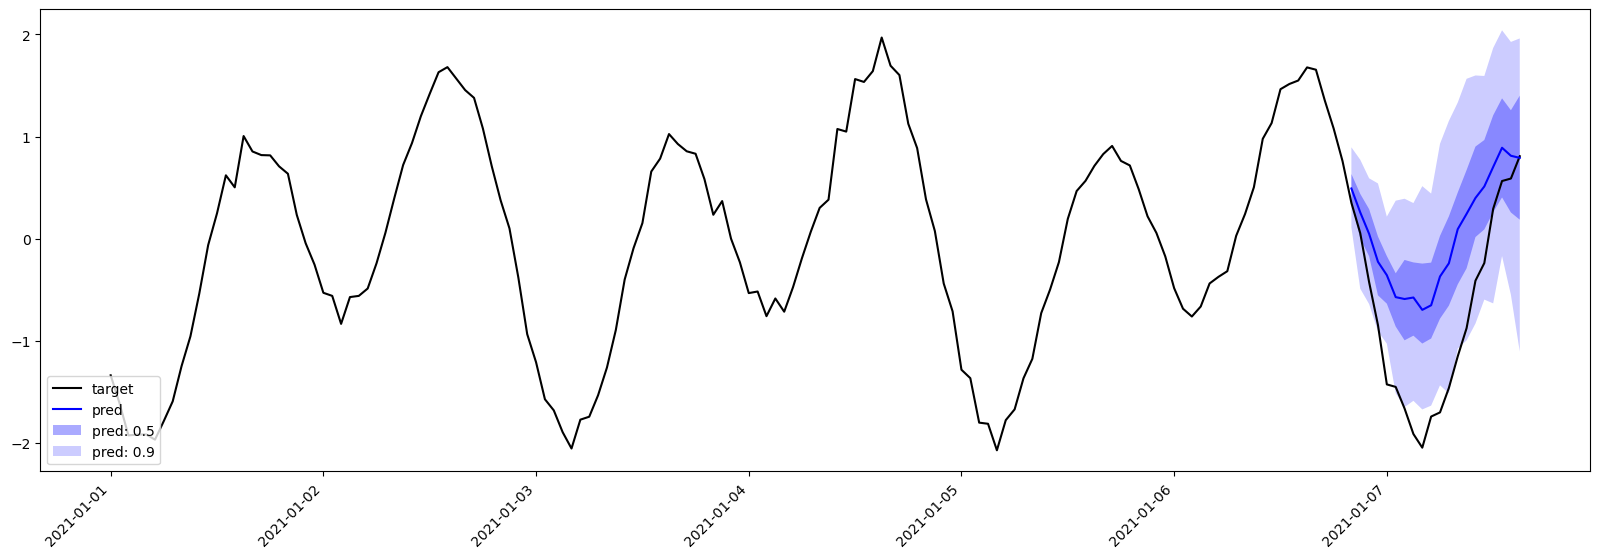

In [80]:
plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)

In [81]:
plt.show()

# Dimensionality reduction

In [82]:
model.__class__

uni2ts.model.moirai.forecast.MoiraiForecast

In [83]:
embs = forecast.samples

In [84]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 1
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 4%
-- cuml.UMAP -- False
GPU | Used mem: 1
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 4%


In [85]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

NameError: name 'hdbscan' is not defined

In [ ]:
prjs_plt = plot_projections(prjs, umap_params)

In [ ]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

In [86]:
model._get_distr(
    32, past_target, past_observed_target, past_observed_target, feat_dynamic_real = None, observed_feat_dynamic_real = None)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

## Toy

### Load dataset
Esta parte debería hacerse ejecutando 01 y utilizando el artefacto W&B

In [35]:
#| export
verbose                       = 1  
show_plots                    = False
reset_kernel                  = False
pre_configured_case           = True 
case_id                       = 7 
frequency_factor              = 1
frequency_factor_change_alias = True 
cuda_device                   = 0

In [36]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad
base_path = Path.home()
import dvats.config as cfg_
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df_toy = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df_toy = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df_toy = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df_toy = df_toy.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df_toy.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df_toy = df_toy.drop(col_name, axis=1)
    
if verbose > 0: display(df_toy.head())
df_toy = infer_or_inject_freq(
    df_toy, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: 
    print(f"--------> {df_toy.index.freq}")
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df_toy = df_toy.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df_toy.columns)}')
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df_toy.replace(config.missing_values_constant, np.nan, inplace=True)
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df_toy  # Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None


Pre configured case id: 7
Selecting  stumpy_toy_0
normalize_training: False
date_offset: None
date_format: %Y-%m-%d %H:%M:%S
wandb_artifacts_path: ./data/wandb_artifacts
csv_config: {'header': None} -> {}
start_date: None
range_testing: None
range_training: None
resampling_freq: None
test_split: None
artifact_name: PulsusParadoxus-SP02 -> toy
time_col: None
data_fpath: ~/data/PulsusParadoxusSP02_30_10000.csv -> ~/data/toy.csv
missing_values_constant: None
data_cols: [0] -> []
missing_values_technique: None
use_wandb: True
freq: 1s
joining_train_test: False
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


--------> <Second>
Num. variables: 3
rg None | test_split None


In [37]:
ds_toy = PandasDataset(dict(df_toy))

In [38]:
df_toy.shape

(550, 3)

In [39]:
df_toy.head()

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


## Predict toy with MOIRAI

In [40]:
SIZE_toy = "small"  # model size: choose from {'small', 'base', 'large'}
PDT_toy  = 30       # prediction length: any positive integer
CTX_toy  = 550      # context length: any positive integer
PSZ_toy  = "auto"   # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ_toy  = 64       # batch size: any positive integer
TEST_toy = 225      # test set length: any positive integer

In [41]:
train_toy, test_template_toy = split(
    ds_toy, offset=-TEST_toy
)

In [ ]:
? train_toy

Checking content for understanding TrainingDataset

In [42]:
train_toy_ds = train_toy.dataset
print(f"Number of samples: {len(train_toy_ds)}")
for entry in train_toy_ds:
    start = entry['start']  # Accede al inicio de la serie temporal
    target = entry['target']  # Accede a los valores del objetivo
    item_id = entry['item_id']  # Accede al ID del item
    print(f"Serie: {item_id}, Start: {start}, Target Length: {len(target)}")


Number of samples: 3
Serie: T3, Start: 1970-01-01 00:00:00, Target Length: 550
Serie: T2, Start: 1970-01-01 00:00:00, Target Length: 550
Serie: T1, Start: 1970-01-01 00:00:00, Target Length: 550


In [ ]:
? test_template_toy

In [ ]:
def print_ds(x):
    ds = x.dataset
    for entry in ds:
        start = entry['start']  # Accede al inicio de la serie temporal
        target = entry['target']  # Accede a los valores del objetivo
        item_id = entry['item_id']  # Accede al ID del item
        print(f"Serie: {item_id}, Start: {start}, Target Length: {len(target)}")

In [ ]:
print_ds(test_template_toy)

### Forecast

#### Rolling window

In [43]:
# Construct rolling window evaluation
test_data_toy = test_template_toy.generate_instances(
    prediction_length=PDT_toy,  # number of time steps for each prediction
    windows=TEST_toy // PDT_toy,  # number of windows in rolling window evaluation
    distance=PDT_toy,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [44]:
m = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}")

In [ ]:
?? m

In [ ]:
m.mask_encoding

In [ ]:
print(m)

In [ ]:
? m.forward

In [45]:
past_target = torch.randn(5,30,2)
past_observed_target = torch.ones_like(past_target, dtype = torch.bool)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

In [46]:
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


In [47]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
    prediction_length=48,
    context_length=168,
    patch_size=32,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [59]:
model._get_distr(
    32, past_target, past_observed_target, past_observed_target, feat_dynamic_real = None, observed_feat_dynamic_real = None)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [48]:
x = torch.randn(2,1,30)

In [ ]:
df.shape

In [49]:
past_target = torch.randn(2,168,1)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

In [51]:
past_target.shape

torch.Size([2, 168, 1])

In [52]:
past_observed_target.shape

torch.Size([2, 168, 1])

In [53]:
past_is_pad.shape

torch.Size([2, 168])

In [50]:
res = model(past_target=past_target, past_observed_target = past_observed_target, past_is_pad = past_is_pad)
res.shape


torch.Size([2, 100, 48])

In [ ]:
? m.mask_encoding 

#### Download model weights

In [ ]:
# Prepare pre-trained model by downloading model weights from huggingface hub
timer = dvats.utils.Time()
timer.start()
model_toy = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT_toy,
    context_length=CTX_toy,
    patch_size=PSZ_toy,
    num_samples=100,
    target_dim=1, # por qué aquí no puedo poner las tres?
    feat_dynamic_real_dim=ds_toy.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds_toy.num_past_feat_dynamic_real,
)
timer.end()
timer.show()

¡ DISCLAIMER !

Aquí estoy haciendo caso a chatGPT porque el modelo está basado en gluonts y no tengo idea de cómo sacar los embeddings. Víctor dice que ha bicheado la herramienta. Si puede echar un ojo a esta parte, lo agradezco.

In [ ]:
activated_layers = []

In [ ]:
def capture_embeddings(module, input, output, verbose = 1):
    if verbose > 0: 
        print("Hook activado")  # Para confirmar que el hook se activa
    captured_embeddings.append(output.detach())

def print_layer_names(module, input, output):
    print("Capa ejecutada:", module.__class__.__name__)

def register_layer_names(module):
    module.register_forward_hook(lambda m, i, o: activated_layers.append(m.__class__.__name__))

In [ ]:
model_toy.apply(register_layer_names)

In [ ]:
captured_embeddings = []
#hook = model_toy.module.mask_encoding.register_forward_hook(capture_embeddings)

In [ ]:
model_toy.eval()

predictor_toy = model_toy.create_predictor(batch_size=BSZ_toy)
forecasts_toy = predictor_toy.predict(test_data_toy.input)

In [ ]:
hook.remove()

In [ ]:
captured_embeddings

In [ ]:
activated_layers

In [ ]:
embs = torch.stack(captured_embeddings)

In [ ]:
print_ds(test_data_toy.input.test_data)

input_it = iter(test_data_toy.input)
label_it = iter(test_data_toy.label)
forecast_it = iter(forecasts_toy)

In [ ]:
inp_toy = next(input_it)
label_toy = next(label_it)
forecast_toy = next(forecast_it)

In [ ]:
plot_single(
    inp_toy, 
    label_toy, 
    forecast_toy, 
    context_length=CTX_toy,
    name="pred",
    show_label=True,
)
plt.show()

In [ ]:
from uni2ts.eval_util.plot import plot_next_multi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Suponiendo que tienes 3 variables y quieres visualizar 5 predicciones
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 3 filas (una por variable), 5 columnas (una por predicción)
fig.suptitle('Predicciones Multivariantes')

# Llamada a plot_next_multi
plot_next_multi(
    axes=axes,
    input_it=input_it,  # Asegúrate de que este iterador proporcione los datos correctos
    label_it=label_it,
    forecast_it=forecast_it,
    context_length=CTX_toy,
    intervals=(0.5, 0.9),  # Intervalos de confianza
    show_label=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Check Toy Embeddings

Proceso global de MOIRAI según el apartado de "Architecture":
MTS = {TS1, ..., TSd}
1) Flatten [TS1, ..., TSd]
2) Multi patch size input projection layer
   Patches are projected into vector representations
4) Mask: learnable embedding
   Replace patches falling within the forecast horizon
5) Multi-patch size output projection into the parameters of the ¿mixture distribution?
   Decode the output tokens

Utiliza: 
Encoder-only transformers
Prenormalization
RMSNorm
query_key normalization
SwiGLU 

all biases are omitted in all layers

In [ ]:
? model_toy.module
#? MoiraiModule

In [ ]:
? nn.embeding

Asi, entiendo que los embeddings se aprenden en la capa mask_encoding

In [ ]:
?? torch.nn.Embedding

In [ ]:
? predictor_toy

In [ ]:
? model_toy

In [ ]:
mask_embeddings = model_toy.module.mask_encoding.weight.data

In [ ]:
embs_toy = forecast_toy.samples

In [ ]:
? model_toy.module

In [ ]:
? model_toy.module.mask_encoding.weight.data

In [ ]:
embs_toy.shape

In [ ]:
prjs_toy = get_UMAP_prjs(embs_toy, cpu=False, **umap_params)

In [ ]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_toy)
clusters_labels = clusters.labels_

In [ ]:
prjs_plt_toy = plot_projections(prjs_toy, umap_params)

In [ ]:
prjs_plt_toy = plot_projections_clusters(prjs_toy, clusters_labels, umap_params)

Mirando información

In [ ]:
? model_toy

In [ ]:
? MoiraiForecast